In [1]:
import numpy as np
import torch
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
from tqdm import trange
from tqdm.notebook import tnrange

from sklearn import preprocessing
import pandas as pd
import os

In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
def transform_dataset(df):
    """

    :param df:
    :return: Tuple of the transformed dataset and the labels Y and S
    """

    df_binary = df[(df["race"] == "Caucasian") | (df["race"] == "African-American")]

    del df_binary['c_jail_in']
    del df_binary['c_jail_out']

    ##separated class from the rests of the features
    # remove unnecessary dimensions from Y -> only the decile_score remains
    Y = df_binary['decile_score']    
    del df_binary['decile_score']
    Y_true = df_binary['two_year_recid']
    del df_binary['two_year_recid']
    del df_binary['score_text']

    S = df_binary['race']
    del df_binary['race']
    del df_binary['is_recid']

    # set sparse to False to return dense matrix after transformation and keep all dimensions homogeneous
    encod = preprocessing.OneHotEncoder(sparse=False)
    
    data_to_encode = df_binary.to_numpy()
    feat_to_encode = data_to_encode[:, 0]
    # print(feat_to_encode)
    # transposition
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    # print(feat_to_encode)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_binary_encoded = pd.DataFrame(encoded_feature)

    feat_to_encode = data_to_encode[:, 1]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_encoded_feature = pd.DataFrame(encoded_feature)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    # feature [2] [3] [4] [5] [6] [7] [8] has to be put between 0 and 1

    for i in range(2, 9):
        encoded_feature = data_to_encode[:, i]
        ma = np.amax(encoded_feature)
        mi = np.amin(encoded_feature)
        encoded_feature = (encoded_feature - mi) / (ma - mi)
        df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    feat_to_encode = data_to_encode[:, 9]
    feat_to_encode = feat_to_encode.reshape(-1, 1)
    encoded_feature = encod.fit_transform(feat_to_encode)

    df_encoded_feature = pd.DataFrame(encoded_feature)

    df_binary_encoded = pd.concat([df_binary_encoded, pd.DataFrame(encoded_feature)], axis=1)

    return df_binary_encoded, Y, S, Y_true


In [4]:
df = pd.read_csv(os.path.join("..", "data", "csv", "scikit",
                                  "compas_recidive_two_years_sanitize_age_category_jail_time_decile_score.csv"))

df_binary, Y, S, Y_true = transform_dataset(df)

#df_outcome = pd.DataFrame(np.array([S, Y]).T, columns=['race', 'true'])


In [5]:
x_tensor = torch.tensor(df_binary.to_numpy().astype(np.float32))
y_tensor = torch.tensor(Y.to_numpy().reshape(-1,1).astype(np.float32))
l_tensor = torch.tensor(Y_true.to_numpy().reshape(-1,1).astype(np.float32))
s_tensor = torch.tensor(preprocessing.OneHotEncoder().fit_transform(np.array(S).reshape(-1, 1)).toarray())

In [6]:
class CustomDataset(Dataset):
    def __init__(self, x_tensor, y_tensor, s_tensor):
        self.x = x_tensor
        self.y = y_tensor
        self.s = s_tensor

    def __getitem__(self, index):
        return self.x[index], self.y[index], self.s[index]

    def __len__(self):
        return len(self.x)

In [7]:
dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor) # dataset = CustomDataset(x_tensor, y_tensor)

In [8]:
base_size = len(dataset)//10
split = [7*base_size,1*base_size, len(dataset)-8*base_size] # Train, validation, test

In [9]:
train_dataset, val_dataset, test_dataset = random_split(dataset, split)

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=128)
test_loader = DataLoader(dataset=test_dataset, batch_size=128)

In [11]:
from torch.autograd import Function

class GradientReversalFunction(Function):
    """
    Gradient Reversal Layer from:
    Unsupervised Domain Adaptation by Backpropagation (Ganin & Lempitsky, 2015)
    Forward pass is the identity function. In the backward pass,
    the upstream gradients are multiplied by -lambda (i.e. gradient is reversed)
    """

    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grads):
        lambda_ = ctx.lambda_
        lambda_ = grads.new_tensor(lambda_)
        dx = -lambda_ * grads
        return dx, None


class GradientReversal(torch.nn.Module):
    def __init__(self, lambda_=1):
        super(GradientReversal, self).__init__()
        self.lambda_ = lambda_

    def forward(self, x):
        return GradientReversalFunction.apply(x, self.lambda_)

In [12]:
class Net(nn.Module):

    def __init__(self):
        super(Net, self).__init__()
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)
        self.grl = GradientReversal(100)
        self.fc4 = nn.Linear(64, 2)
        
        #self.grl = GradientReversal(100)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = F.dropout(x, 0.1)
        x = self.fc2(x)
        x = F.relu(x)
        hidden = F.dropout(x, 0.1)
        y = self.fc3(hidden)
        y = F.dropout(y, 0.1)
        s = self.grl(hidden)
        s = self.fc4(s)
        #s = F.sigmoid(s)
        s = F.dropout(s, 0.1)
        return y,s

In [13]:
def make_train_step(model: Net, loss_fn, optimizer):
    def _train_step(x, y):
        optimizer.zero_grad()
        yhat = model(x)
        loss = loss_fn(y, yhat)
        loss.backward()
        optimizer.step()
        return loss.item()
    return _train_step

In [14]:
def weights_init_uniform_rule(m):
        classname = m.__class__.__name__
        # for every Linear layer in a model..
        if classname.find('Linear') != -1:
            # get the number of the inputs
            n = m.in_features
            y = 1.0/np.sqrt(n)
            m.weight.data.uniform_(-y, y)
            m.bias.data.fill_(0)
            

In [15]:
torch.manual_seed(0)

model = Net()
criterion = nn.MSELoss()
criterion_bias = nn.CrossEntropyLoss()
optimizer =optim.Adagrad(model.parameters())

n_epochs = 50
training_losses = []
validation_losses = []

In [16]:
t_prog = trange(n_epochs, desc='Progress', leave=True)
#t_prog = trange(50)

for epoch in range(n_epochs):
    model.train()

    batch_losses = []
    for x_batch, y_batch, _,s_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
         # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, outputs_protected = model(x_batch)
        loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val, _,s_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat, s_hat = model(x_val)
            val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)
    if epoch % 50 == 0:
        print({"epoch": epoch, "training_loss": training_loss, "validation_loss": validation_loss})  # print last metrics

Progress:   0%|          | 0/50 [00:00<?, ?it/s]

{'epoch': 0, 'training_loss': 16.807166790140087, 'validation_loss': 10.89204779362784}


In [17]:
criterion_bias(outputs_protected, s_batch.argmax(dim=1))

tensor(0.6321, grad_fn=<NllLossBackward>)

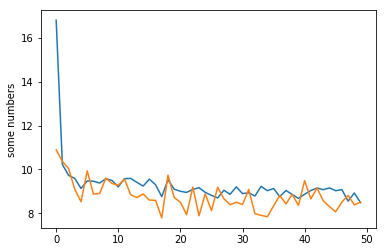

In [18]:
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(len(validation_losses)), validation_losses)
#plt.scatter(x_tensor, y_out.detach().numpy())
plt.ylabel('some numbers')
plt.show()

In [19]:
with torch.no_grad():
    test_losses = []
    test_results = []
    for x_test, y_test, ytrue, s_true in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        model.eval()
        yhat, s_hat = model(x_test)
        print(yhat.shape)
        test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
        test_losses.append(val_loss)
        test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
    print({"Test loss": np.mean(test_losses)})
 

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([38, 1])
{'Test loss': 6.920967439573073}


In [20]:
results             = test_results[0]['y_hat']
outcome             = test_results[0]['y_true']
compas              = test_results[0]['y_compas']
protected_results   = test_results[0]['s']
protected              = test_results[0]['s_hat']
for r in test_results[1:]:
    results = torch.cat((results, r['y_hat']))
    outcome = torch.cat((outcome, r['y_true']))
    compas = torch.cat((compas, r['y_compas']))
    protected_results = torch.cat((protected_results, r['s']))
    protected = torch.cat((protected, r['s_hat']))
    print(results.shape)
   

torch.Size([256, 1])
torch.Size([384, 1])
torch.Size([512, 1])
torch.Size([640, 1])
torch.Size([768, 1])
torch.Size([896, 1])
torch.Size([1024, 1])
torch.Size([1062, 1])


In [20]:
((results[:,0] > 8) == outcome[:,0]).float().mean() 

tensor(0.5395)

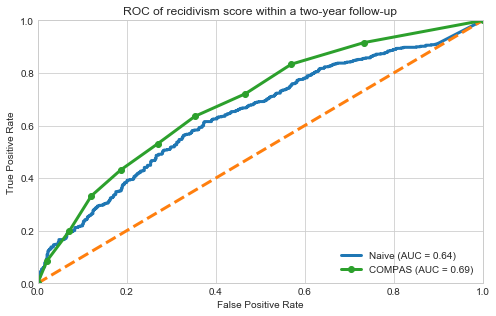

In [21]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], results[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Naive (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], compas[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-o",
    label='COMPAS (AUC = %0.2f)'% roc_auc,  linewidth=3)



# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

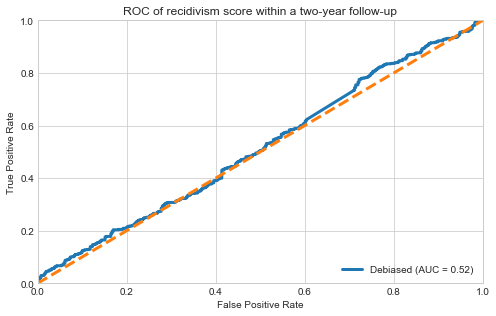

In [22]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(protected_results[:,0], protected[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Debiased (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
#fig.savefig("roc_curve.png", dpi=300,  transparent=True)

In [23]:
protected[:,0]

tensor([-0.1607, -0.0892,  0.0384,  ...,  0.1839, -0.2070,  0.1104])

In [24]:
criterion(yhat, y_val)

/Users/pieter/.local/share/virtualenvs/ethicsML-IsNwXYYM/lib/python3.7/site-packages/torch/nn/modules/loss.py:431: UserWarning: Using a target size (torch.Size([15, 1])) that is different to the input size (torch.Size([38, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


RuntimeError: The size of tensor a (38) must match the size of tensor b (15) at non-singleton dimension 0

In [ ]:
x = np.random.rand(100, 1)
true_a, true_b = 1, 2
y = true_a + true_b*x + 0.1*np.random.randn(100, 1)

x_tensor = torch.from_numpy(x).float()
y_tensor = torch.from_numpy(y).float()
y_out = model(x_tensor.to(device))

In [ ]:
x_val = x_val.to(device)
y_val = y_val.to(device)
model.eval()
yhat = model(x_val)
val_loss = loss_fn(y_val, yhat).item()



In [ ]:
np.power(y_val - yhat, 2).mean()

In [ ]:
from sklearn import tree

tree.ExtraTreeRegressor().fit(x_tensor[:3000], y_tensor[:3000]).predict(x_val)

In [ ]:
y_val



In [25]:
from secml.ml.classifiers import CClassifier, CClassifierDNN
from secml.array import CArray

In [26]:
def loss_fn(ys_true, ys_hat):
    y_true = ys_true[0]
    s_true = ys_true[1]
    y_hat = ys_hat[0]
    s_hat = ys_hat[1]
    
    criterion(y_true, y_hat) + criterion_bias(s_true, s_hat.argmax(dim=1))

In [37]:
grl = GradientReversalClassifier(model, 
                   loss=loss_fn, 
                    optimizer=optimizer)

In [38]:
# manually set it to trained
grl._trained = True

In [39]:
grl

GradientReversalClassifier{'classes': None, 'n_features': None, 'preprocess': None, 'model': Net(
  (fc1): Linear(in_features=14, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (grl): GradientReversal()
  (fc4): Linear(in_features=64, out_features=2, bias=True)
), 'trained': True, 'input_shape': (14,), 'softmax_outputs': False, 'loss': <function loss_fn at 0x136ac2680>, 'optimizer': Adagrad (
Parameter Group 0
    eps: 1e-10
    initial_accumulator_value: 0
    lr: 0.01
    lr_decay: 0
    weight_decay: 0
), 'epochs': 10, 'batch_size': 1}

In [27]:
from secml.settings import SECML_PYTORCH_USE_CUDA

use_cuda = torch.cuda.is_available() and SECML_PYTORCH_USE_CUDA


def get_layers(net):
    # TODO remove when dropping support for python 2
    layers = list()
    for name, layer in net._modules.items():
        # If it is a sequential, don't return its name
        # but recursively register all it's module children
        if isinstance(layer, nn.Sequential) or isinstance(layer, BasicBlock):
            layers += [(":".join([name, l]), m) for (l, m) in
                       get_layers(layer)]
        else:
            layers.append((name, layer))
    else:
        return layers

class GradientReversalClassifier(CClassifierDNN):
    """CClassifierPyTorch, wrapper for PyTorch models.

    Parameters
    ----------
    model:
        `torch.nn.Module` object to use as classifier
    loss:
        loss object from `torch.nn`
    optimizer:
        optimizer object from `torch.optim`

    random_state: int or None, optional
        random state to use for initializing the model weights.
        Default value is None.
    preprocess:
        preprocessing module.
    softmax_outputs: bool, optional
        if set to True, a softmax function will be applied to
        the return value of the decision function. Note: some
        implementation adds the softmax function to the network
        class as last layer or last forward function, or even in the
        loss function (see torch.nn.CrossEntropyLoss). Be aware that the
        softmax may have already been applied.
        Default value is False.
    epochs: int
        number of epochs for training the neural network. Default value is 10.
    batch_size: int
        size of the batches to use for loading the data. Default value is 1.
    n_jobs: int
        number of workers to use for data loading and processing. Default value is 1.

    Attributes
    ----------
    class_type : 'pytorch-clf'

    """
    __class_type = 'pytorch-clf'

    def __init__(self, model, loss=None, optimizer=None,
                 input_shape=None,
                 random_state=None, preprocess=None,
                 softmax_outputs=False,
                 epochs=10, batch_size=1, n_jobs=1):

        self._device = self._set_device()
        self._random_state = random_state
        super(GradientReversalClassifier, self).__init__(model=model,
                                                 preprocess=preprocess,
                                                 input_shape=input_shape,
                                                 softmax_outputs=softmax_outputs)
        self._init_model()

        if self._input_shape is None:
            # try to infer from first layer
            first_layer = list(self._model._modules.values())[0]
            if isinstance(first_layer, torch.nn.Linear):
                self._input_shape = (first_layer.in_features,)
            else:
                raise ValueError(
                    "Input shape should be specified if the first "
                    "layer is not a `nn.Linear` module.")

        # check softmax redundancy
        if isinstance(loss, nn.CrossEntropyLoss) and self.check_softmax():
            raise ValueError("Please remove softmax redundancy. Either "
                             "use `torch.nn.NLLLoss` or remove softmax "
                             "layer from the network.")

        self._loss = loss
        self._optimizer = optimizer

        if self._optimizer is not None:
            # check softmax redundancy
            if self.check_softmax() and softmax_outputs:
                self.logger.warning(
                    "Softmax layer has been defined in the network. Disabling "
                    "parameter softmax_outputs.")
                self._softmax_outputs = False
            else:
                self._softmax_outputs = softmax_outputs
        else:
            self._softmax_outputs = False

        self._epochs = epochs
        self._batch_size = batch_size

        if self._batch_size is None:
            self.logger.info(
                "No batch size passed. Value will be set to the default "
                "value of 1.")
            self._batch_size = 1

        self._n_jobs = n_jobs

        # hooks for getting intermediate outputs
        self._handlers = []
        # will store intermediate outputs from the hooks
        self._intermediate_outputs = None
        self._cached_s = None
        self._cached_layer_output = None

    @property
    def loss(self):
        """Returns the loss function used by classifier."""
        return self._loss

    @property
    def model(self):
        """Returns the model used by classifier."""
        return self._model

    @property
    def optimizer(self):
        """Returns the optimizer used by classifier."""
        return self._optimizer

    @property
    def epochs(self):
        """Returns the number of epochs for which the model
        will be trained."""
        return self._epochs

    @property
    def batch_size(self):
        """Returns the batch size used for the dataset loader."""
        return self._batch_size

    @property
    def layers(self):
        """Returns the layers of the model, if possible. """
        if self._model_layers is None:
            if isinstance(self._model, nn.Module):
                self._model_layers = get_layers(self._model)
            else:
                raise TypeError(
                    "The input model must be an instance of `nn.Module`.")
        return self._model_layers

    @property
    def layer_shapes(self):
        if self._model_layer_shapes is None:
            self._model_layer_shapes = {}
            layer_names = self.layer_names
            self.hook_layer_output(layer_names)
            x = torch.randn(size=self.input_shape).unsqueeze(0)
            x = x.to(self._device)
            self._model(x)
            for layer_name, layer in self.layers:
                self._model_layer_shapes[layer_name] = tuple(
                    self._intermediate_outputs[layer].shape)
            self._clean_hooks()
        return self._model_layer_shapes

    @property
    def trained(self):
        """True if the model has been trained."""
        return self._trained

    def get_layer_shape(self, layer_name):
        return self.layer_shapes[layer_name]


    def _clean_hooks(self):
        """Removes previously defined hooks."""
        for handler in self._handlers:
            handler.remove()
        self._intermediate_outputs = None

    def _hook_forward(self, module_name, input, output):
        """Hooks the module's `forward` method so that it stores
        the intermediate outputs as tensors."""

        self._intermediate_outputs[module_name] = output

    def hook_layer_output(self, layer_names=None):
        """
        Creates handlers for the hooks that store the layer outputs.

        Parameters
        ----------
        layer_names : list or str, optional
            List of layer names to hook. Cleans previously
            defined hooks to prevent multiple hook creations.

        """
        if isinstance(layer_names, str):
            layer_names = [layer_names]

        self._clean_hooks()
        self._handlers = []
        self._intermediate_outputs = {}

        for name, layer in get_layers(self._model):
            if name in layer_names:
                self._handlers.append(
                    layer.register_forward_hook(self._hook_forward))
            else:
                pass


    def _set_device(self):
        return torch.device("cuda" if use_cuda else "cpu")

    def n_jobs(self):
        """Returns the number of workers being used for loading
        and processing the data."""
        return self._n_jobs


    def get_params(self):
        """Returns the dictionary of class parameters."""
        loss_params = {'loss': self._loss}
        optim_params = {
            'optimizer': self._optimizer.state_dict()['param_groups'][0]
            if self._optimizer is not None else None
        }
        return SubLevelsDict(
            merge_dicts(super(GradientReversalClassifier, self).get_params(),
                        loss_params, optim_params))


    def get_state(self):
        """Returns the object state dictionary."""
        from copy import deepcopy

        # State of the wrapping classifier
        state = super(GradientReversalClassifier, self).get_state()

        # Map model and optimizer to CPU before saving
        self._model.to(torch.device('cpu'))

        # Unfortunately optimizer does not have a 'to(device)' method
        for opt_state in self._optimizer.state.values():
            for k, v in opt_state.items():
                if isinstance(v, torch.Tensor):
                    opt_state[k] = v.to('cpu')

        # Use deepcopy as restoring device later will change them
        state['model'] = deepcopy(self._model.state_dict())
        state['optimizer'] = deepcopy(self._optimizer.state_dict())

        # Restore device and optimizer
        self._model.to(self._device)

        # Unfortunately optimizer does not have a 'to(device)' method
        for opt_state in self._optimizer.state.values():
            for k, v in opt_state.items():
                if isinstance(v, torch.Tensor):
                    opt_state[k] = v.to(self._device)

        return state


    def set_state(self, state_dict, copy=False):
        """Sets the object state using input dictionary."""
        # TODO: DEEPCOPY FOR torch.load_state_dict?
        self._model.load_state_dict(state_dict.pop('model'))
        self._optimizer.load_state_dict(state_dict.pop('optimizer'))
        super(GradientReversalClassifier, self).set_state(state_dict, copy=copy)


    def check_softmax(self):
        """
        Checks if a softmax layer has been defined in the
        network.

        Returns
        -------
        Boolean value stating if a softmax layer has been
        defined.
        """
        x = torch.ones(tuple([1] + list(self.input_shape)))
        x = x.to(self._device)

        outputs = self._model(x)[0]

        if outputs.sum() == 1:
            return True
        return False


    def __getattribute__(self, key):
        """Get an attribute.

        This allows getting also attributes of the internal PyTorch model,
        loss and optimizer."""
        try:
            # If we are not getting the model itself
            if key not in ['_model', '_optimizer']:
                if hasattr(self, '_model') and key in self._model._modules:
                    return self._model[key]
                elif hasattr(self, '_optimizer') and \
                        self._optimizer is not None and \
                        key in self._optimizer.state_dict()['param_groups'][0]:
                    if len(self._optimizer.state_dict()['param_groups']) == 1:
                        return self._optimizer.param_groups[0][key]
                    else:
                        raise NotImplementedError(
                            "__getattribute__ is not yet "
                            "supported for optimizers with "
                            "more than one element in "
                            "param_groups.")
        except KeyError:
            pass  # Parameter not found in PyTorch model
            # Try to get the parameter from self
        return super(GradientReversalClassifier, self).__getattribute__(key)

    def __setattr__(self, key, value):
        """Set an attribute.

        This allow setting also the attributes of the internal PyTorch model.

        """
        if isinstance(value, (torch.Tensor, torch.nn.Module)):
            value = value.to(self._device)
        if hasattr(self, '_model') and key in self._model._modules:
            self._model._modules[key] = value
        elif hasattr(self, '_optimizer') and \
                self._optimizer is not None and \
                key in self._optimizer.state_dict()['param_groups'][0]:
            self._optimizer.param_groups[0][key] = value
        else:  # Otherwise, normal python set behavior
            super(GradientReversalClassifier, self).__setattr__(key, value)

    def _init_model(self):
        """Initialize the PyTorch Neural Network model."""
        # Setting random seed
        if self._random_state is not None:
            torch.manual_seed(self._random_state)

        # Make sure that model is a proper PyTorch module
        if not isinstance(self._model, nn.Module):
            raise TypeError("`model` must be a `torch.nn.Module`.")

        self._model = self._model.to(self._device)

    @staticmethod
    def _to_tensor(x):
        """Convert input CArray to tensor."""
        if not isinstance(x, CArray):
            raise ValueError("A `CArray` is required as "
                             "input to the `_to_tensor` method.")
        x = x.tondarray()
        x = torch.from_numpy(x)
        x = x.type(torch.FloatTensor)
        if use_cuda is True:
            x = x.cuda(device=torch.device('cuda'))
        return x

    @staticmethod
    def _from_tensor(x):
        """Convert input tensor to CArray"""
        if not isinstance(x, torch.Tensor):
            raise ValueError("A `torch.Tensor` is required as "
                             "input to the `_from_tensor` method.")
        return CArray(x.cpu().numpy()).astype(float)

    def _data_loader(self, data, labels=None, batch_size=10, shuffle=False,
                     num_workers=1):
        """
        Returns `torch.DataLoader` generated from
        the input CDataset.

        Parameters
        ----------
        data : CArray
            CArray containing the input data to load.
        labels : CArray
            CArray containing the labels for the data.
        batch_size : int, optional
            Size of the batches to load for each iter of
            the data loader.
            Default value is 10.
        shuffle : bool, optional
            Whether to shuffle the data before dividing in batches.
            Default value is False.
        num_workers : int, optional
            Number of processes to use for loading the data.
            Default value is 1.

        Returns
        -------
        `CDataLoaderPyTorch` iterator for loading the dataset in batches,
        optionally shuffled, with the specified number of workers.

        """
        transform = transforms.Lambda(lambda x: x.reshape(self._input_shape))
        return CDataLoaderPyTorch(data, labels,
                                  batch_size, shuffle=shuffle,
                                  transform=transform,
                                  num_workers=num_workers, ).get_loader()

    def _fit(self, dataset):
        """Fit PyTorch model."""

        if any([self._optimizer is None,
                self._loss is None]):
            raise ValueError("Optimizer and loss should both be defined "
                             "in order to fit the model.")

        train_loader = self._data_loader(dataset.X, dataset.Y,
                                         batch_size=self._batch_size)

        for epoch in range(self._epochs):
            running_loss = 0.0
            for i, data in enumerate(train_loader):
                inputs, labels = data
                inputs = inputs.to(self._device)
                labels = labels.to(self._device)
                self._optimizer.zero_grad()
                outputs = self._model(inputs)
                loss = self._loss(outputs, labels)
                loss.backward()
                self._optimizer.step()

                # print statistics
                running_loss += loss.item()
                if i % 2000 == 1999:  # print every 2000 mini-batches
                    self.logger.info('[%d, %5d] loss: %.3f' %
                                     (epoch + 1, i + 1, running_loss / 2000))
                    running_loss = 0.0

        self._trained = True
        return self._model

    def _forward(self, x):
        """Forward pass on input x.
        Returns the output of the layer set in _out_layer.
        If _out_layer is None, the last layer output is returned,
        after applying softmax if softmax_outputs is True.

        Parameters
        ----------
        x : CArray
            preprocessed array, ready to be transformed by the current module.

        Returns
        -------
        CArray
            Transformed input data.

        """
        data_loader = self._data_loader(x, num_workers=self._n_jobs,
                                        batch_size=self._batch_size)

        # Switch to evaluation mode
        self._model.eval()

        out_shape = self.n_classes if self._out_layer is None else \
            reduce((lambda x, y: x * y), self.layer_shapes[self._out_layer])
        output = torch.empty((len(data_loader.dataset), out_shape))

        for batch_idx, (s, _) in enumerate(data_loader):
            # Log progress
            self.logger.info(
                'Classification: {batch}/{size}'.format(batch=batch_idx,
                                                        size=len(data_loader)))

            s = s.to(self._device)

            if self._cached_x is None:
                with torch.no_grad():
                    ps = self._get_layer_output(s, self._out_layer)

            else:
                # keep track of the gradient in s tensor
                s.requires_grad = True
                ps = self._get_layer_output(s, self._out_layer)
                self._cached_s = s
                self._cached_layer_output = ps

            output[batch_idx * self.batch_size:
                   batch_idx * self.batch_size + len(s)] = \
                ps.view(ps.size(0), -1).detach()

        # Apply softmax-scaling if needed
        if self._softmax_outputs is True and self._out_layer is None:
            scores = output.softmax(dim=1)
        else:
            scores = output

        scores = self._from_tensor(scores)
        return scores

    def _get_layer_output(self, s, layer_name=None):
        """Returns the output of the desired net layer as `Torch.Tensor`.

        Parameters
        ----------
        s : torch.Tensor
            Input tensor to forward propagate.
        layer_name : str or None, optional
            Name of the layer to hook for getting the output.
            If None, the output of the last layer will be returned.

        Returns
        -------
        torch.Tensor
            Output of the desired layer(s).

        """
        if layer_name is None:  # Directly use the last layer
            return self._model(s)  # Forward pass

        elif isinstance(layer_name, str):

            self.hook_layer_output(layer_name)
            self._model(s)

            if not self._intermediate_outputs:
                raise ValueError("None of requested layers were found")

            return list(self._intermediate_outputs.values())[0]
        else:
            raise ValueError("Pass layer names as a list or just None "
                             "for last layer output.")

    def _backward(self, w):
        """Returns the gradient of the DNN - considering the output layer set
        in _out_layer - wrt data.

        Parameters
        ----------
        w : CArray
            Weights that are pre-multiplied to the gradient
            of the module, as in standard reverse-mode autodiff.

        Returns
        -------
        gradient : CArray
            Accumulated gradient of the module wrt input data.
        """
        if w is not None:
            w = self._to_tensor(w.atleast_2d()).reshape(
                self._cached_layer_output.shape)
        else:
            raise ValueError(
                "Function `_backward` needs the `w` array to run backward with.")

        # Apply softmax-scaling if needed (only if last layer is required)
        if self.softmax_outputs is True and self._out_layer is None:
            out_carray = self._from_tensor(
                self._cached_layer_output.squeeze(0).data)
            softmax_grad = CSoftmax().gradient(
                out_carray, y=self._cached_layer_output)
            self._cached_layer_output *= self._to_tensor(
                softmax_grad.atleast_2d()).unsqueeze(0)
        w = w.to(self._device)

        if self._cached_s.grad is not None:
            self._cached_s.grad.data._zero()

        self._cached_layer_output.backward(w)

        return self._from_tensor(self._cached_s.grad.data.view(
            -1, self.n_features))

    def save_model(self, filename):
        """
        Stores the model and optimizer's parameters.

        Parameters
        ----------
        filename : str
            path of the file for storing the model

        """
        state = {
            'model_state': self._model.state_dict(),
            'optimizer_state': self._optimizer.state_dict(),
            'n_features': self.n_features,
            'classes': self.classes,
        }

        torch.save(state, filename)


    def load_model(self, filename, classes=None):
        """
        Restores the model and optimizer's parameters.
        Notes: the model class and optimizer should be
        defined before loading the params.

        Parameters
        ----------
        filename : str
            path where to find the stored model
        classes : list, tuple or None, optional
            This parameter is used only if the model was stored
            with native PyTorch.
            Class labels (sorted) for matching classes to indexes
            in the loaded model. If classes is None, the classes
            will be assigned new indexes from 0 to n_classes.

        """
        state = torch.load(filename, map_location=self._device)
        keys = ['model_state', 'optimizer_state', 'n_features', 'classes']
        if all(key in state for key in keys):
            if classes is not None:
                self.logger.warning(
                    "Model was saved within `secml` framework. "
                    "The parameter `classes` will be ignored.")
            # model was stored with save_model method
            self._model.load_state_dict(state['model_state'])
            self._optimizer.load_state_dict(state['optimizer_state'])
            self._n_features = state['n_features']
            self._classes = state['classes']
        else:  # model was stored outside secml framework
            try:
                self._model.load_state_dict(state)
                # This part is important to prevent not fitted
                if classes is None:
                    self._classes = CArray.arange(
                        self.layer_shapes[self.layer_names[-1]][1])
                else:
                    self._classes = CArray(classes)
                self._n_features = reduce(lambda x, y: x * y, self.input_shape)
                self._trained = True
            except Exception:
                self.logger.error(
                    "Model's state dict should be stored according to "
                    "PyTorch docs. Use `torch.save(model.state_dict())`.")

In [28]:
# Should be chosen depending on the optimization problem
solver_params = {
    'eta': 0.3,
    'max_iter': 100,
    'eps': 1e-4
}

In [29]:
from secml.data.c_dataset import CDataset

In [30]:
def attack_keras_model(X, Y, S, nb_attack = 25, dmax=0.1):
    """
    Generates an adversarial attack on a general model.

    :param df: Original inputs on which the model is trained
    :return: Adversarial dataset (i.e. new data points + original input)
    """
    
    from secml.data import CDataset
    from secml.array import CArray

    # secML wants all dimensions to be homogeneous (we had previously float and int in X)
    data_set_encoded_secML = CArray(X, dtype=float, copy=True)
    data_set_encoded_secML = CDataset(data_set_encoded_secML, Y)

    n_tr = round(0.66 * X.shape[0])
    n_ts = X.shape[0] - n_tr

    logger.debug(X.shape)
    logger.debug(n_tr)
    logger.debug(n_ts)

    from secml.data.splitter import CTrainTestSplit
    splitter = CTrainTestSplit(train_size=n_tr, test_size=n_ts)

    # Use training set for the classifier and then pick points from an internal test set.
    tr_set_secML, ts_set_secML = splitter.split(data_set_encoded_secML)

    # tr_set_secML = CDataset(X_train,Y_train)
    # ts_set_secML = CDataset(X_test,Y_test)

    # Create a surrogate classifier

    # Creation of the multiclass classifier
    from secml.ml.classifiers import CClassifierSVM
    from secml.ml.classifiers.multiclass import CClassifierMulticlassOVA
    from secml.ml.kernel import CKernelRBF
    clf = CClassifierMulticlassOVA(CClassifierSVM, kernel=CKernelRBF())

    # Parameters for the Cross-Validation procedure
    xval_params = {'C': [1e-4, 1e-3, 1e-2, 0.1, 1], 'kernel.gamma': [0.01, 0.1, 1, 10, 100, 1e3]}

    # Let's create a 3-Fold data splitter
    random_state = 999

    from secml.data.splitter import CDataSplitterKFold
    xval_splitter = CDataSplitterKFold(num_folds=3, random_state=random_state)

    # Select and set the best training parameters for the classifier
    logger.debug("Estimating the best training parameters...")
    best_params = clf.estimate_parameters(
        dataset=tr_set_secML,
        parameters=xval_params,
        splitter=xval_splitter,
        metric='accuracy',
        perf_evaluator='xval'
    )
    logger.debug("The best training parameters are: ", best_params)

    logger.debug(clf.get_params())
    logger.debug(clf.num_classifiers)

    # Metric to use for training and performance evaluation
    from secml.ml.peval.metrics import CMetricAccuracy
    metric = CMetricAccuracy()

    # Train the classifier
    clf.fit(tr_set_secML)
    logger.debug(clf.num_classifiers)

    # Compute predictions on a test set
    y_pred = clf.predict(ts_set_secML.X)

    # Evaluate the accuracy of the classifier
    acc = metric.performance_score(y_true=ts_set_secML.Y, y_pred=y_pred)

    logger.debug("Accuracy on test set: {:.2%}".format(acc))

    # Prepare attack configuration

    noise_type = 'l2'   # Type of perturbation 'l1' or 'l2'
    lb, ub = 0, 1       # Bounds of the attack space. Can be set to `None` for unbounded
    y_target = None     # None if `error-generic` or a class label for `error-specific`

    # Should be chosen depending on the optimization problem
    solver_params = {
        'eta': 0.1,         # grid search resolution
        'eta_min': 0.1,
        'eta_max': None,    # None should be ok
        'max_iter': 1000,
        'eps': 1e-2         # Tolerance on the stopping crit.
    }

    # Run attack

    from secml.adv.attacks.evasion import CAttackEvasionPGDLS
    pgd_ls_attack = CAttackEvasionPGDLS(
        classifier=clf,
        surrogate_classifier=clf,
        surrogate_data=tr_set_secML,
        distance=noise_type,
        dmax=dmax,
        lb=lb, ub=ub,
        solver_params=solver_params,
        y_target=y_target)
    
    nb_feat = X.shape[1]

    result_pts = np.empty([nb_attack, nb_feat])
    result_class = np.empty([nb_attack, 1])

    # take a point at random being the starting point of the attack and run the attack
    import random
    for nb_iter in range(0, nb_attack - 1):
        rn = random.randint(0, ts_set_secML.num_samples)
        x0, y0 = ts_set_secML[rn, :].X, ts_set_secML[rn, :].Y,

        try:
            y_pred_pgdls, _, adv_ds_pgdls, _ = pgd_ls_attack.run(x0, y0)
            adv_pt = adv_ds_pgdls.X.get_data()
            # np.asarray([np.asarray(row, dtype=float) for row in y_tr], dtype=float)
            result_pts[nb_iter] = adv_pt
            result_class[nb_iter] = y_pred_pgdls.get_data()[0]
        except ValueError:
            logger.warning("value error on {}".format(nb_iter))

    return result_pts, result_class, ts_set_secML[:nb_attack, :].Y

In [34]:
result_pts, result_class, labels = attack_keras_model(
                CArray(train_dataset[:][0]),
                Y=CArray((train_dataset[:][1][:,0] > 4).int()),
                S=train_dataset[:][3],
                nb_attack=25)

2020-03-07 13:40:47,453 - __main__ - WARNING - value error on 18


In [32]:

CArray((train_dataset[:][1][:,0] > 4).float())

CArray(3689,)(dense: [1. 0. 1. ... 1. 0. 1.])

In [33]:
import logging
logger = logging.getLogger(__name__)


In [44]:
result_pts.round(2)


array([[ 0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  2.00000000e-002,
         2.00000000e-002,  5.00000000e-002,  2.00000000e-002,
         4.90000000e-001,  8.00000000e-002,  8.00000000e-002,
         0.00000000e+000,  1.00000000e+000],
       [ 0.00000000e+000,  1.00000000e+000,  0.00000000e+000,
         1.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         5.80000000e-001,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  1.00000000e+000],
       [ 0.00000000e+000,  1.00000000e+000,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+000,
         3.90000000e-001,  0.00000000e+000,  0.00000000e+000,
         1.00000000e+000,  0.00000000e+000],
       [ 1.00000000e+000,  0.00000000e+000,  1.00000000e+000,
         0.00000000e+000,  0.00000000e+000,  0.00000000e+00

In [35]:
x_tensor = torch.tensor(result_pts.astype(np.float32)).clamp(0,1)
y_tensor = torch.tensor(result_class.reshape(-1,1).astype(np.float32))
l_tensor = torch.tensor(labels.tondarray().reshape(-1,1).astype(np.float32))
s = np.random.randint(2,size=len(result_class))
s_tensor = torch.tensor(np.array([s, 1-s]).T.astype(np.float64))

adversarial_dataset = TensorDataset(x_tensor, y_tensor, l_tensor, s_tensor) # dataset = CustomDataset(x_tensor, y_tensor)

In [36]:
adversarial_dataset[0]

(tensor([0.0000, 1.0000, 1.0000, 0.0000, 0.0000, 0.0200, 0.0079, 0.0048, 0.1433,
         0.5291, 0.0481, 0.0476, 1.0000, 0.0000]),
 tensor([1.]),
 tensor([1.]),
 tensor([0., 1.], dtype=torch.float64))

In [37]:
train_dataset[0]

(tensor([1.0000e+00, 0.0000e+00, 1.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         0.0000e+00, 0.0000e+00, 1.0526e-01, 5.0000e-01, 2.0276e-04, 0.0000e+00,
         1.0000e+00, 0.0000e+00]),
 tensor([7.]),
 tensor([1.]),
 tensor([1., 0.], dtype=torch.float64))

In [38]:
from torch.utils.data.dataset import ConcatDataset

In [39]:
new_train_dataset = ConcatDataset([train_dataset, adversarial_dataset])

In [40]:

len(new_train_dataset)

3714

In [41]:
train_loader = DataLoader(dataset=new_train_dataset, batch_size=128, shuffle=True)

In [42]:
del model

torch.manual_seed(0)

model = Net()
optimizer =optim.Adagrad(model.parameters())

n_epochs = 500
training_losses = []
validation_losses = []

In [43]:
for epoch in range(n_epochs):
    model.train()

    batch_losses = []
    for x_batch, y_batch, _,s_batch in train_loader:
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        
         # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, outputs_protected = model(x_batch)
        loss = criterion(outputs, y_batch) + criterion_bias(outputs_protected, s_batch.argmax(dim=1))
        loss.backward()
        optimizer.step()

        batch_losses.append(loss.item())

    training_loss = np.mean(batch_losses)
    training_losses.append(training_loss)

    with torch.no_grad():
        val_losses = []
        for x_val, y_val, _,s_val in val_loader:
            x_val = x_val.to(device)
            y_val = y_val.to(device)
            model.eval()
            yhat, s_hat = model(x_val)
            val_loss = (criterion(y_val, yhat) + criterion_bias(s_val, s_hat.argmax(dim=1))).item()
            val_losses.append(val_loss)
        validation_loss = np.mean(val_losses)
        validation_losses.append(validation_loss)
    if epoch % 50 == 0:
        print({"epoch": epoch, "training_loss": training_loss, "validation_loss": validation_loss})  # print last metrics

{'epoch': 0, 'training_loss': 15.7065958182017, 'validation_loss': 11.400191631874502}
{'epoch': 50, 'training_loss': 9.252649132410685, 'validation_loss': 10.423410467069411}
{'epoch': 100, 'training_loss': 9.05801083246867, 'validation_loss': 10.113996964058343}
{'epoch': 150, 'training_loss': 9.965144236882528, 'validation_loss': 9.089905014595452}
{'epoch': 200, 'training_loss': 9.44693112373352, 'validation_loss': 10.378030351560378}
{'epoch': 250, 'training_loss': 9.289556709925334, 'validation_loss': 10.872826138100091}
{'epoch': 300, 'training_loss': 9.426040490468344, 'validation_loss': 9.265821877083246}
{'epoch': 350, 'training_loss': 9.373578214645386, 'validation_loss': 9.851336231789057}
{'epoch': 400, 'training_loss': 9.99302814801534, 'validation_loss': 9.99874681528515}
{'epoch': 450, 'training_loss': 9.779155699412028, 'validation_loss': 9.74734701212353}


In [44]:
print(s_batch.shape)

torch.Size([2, 2])


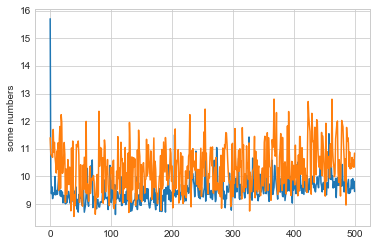

In [45]:
import matplotlib.pyplot as plt

plt.plot(range(len(training_losses)), training_losses)
plt.plot(range(len(validation_losses)), validation_losses)
#plt.scatter(x_tensor, y_out.detach().numpy())
plt.ylabel('some numbers')
plt.show()

In [46]:
from bayesian_model import BayesianModel as bm


In [47]:

with torch.no_grad():
    test_losses = []
    test_results = []
    for x_test, y_test, ytrue, s_true in test_loader:
        x_test = x_test.to(device)
        y_test = y_test.to(device)
        model.eval()
        yhat, s_hat = model(x_test)
        print(yhat.shape)
        test_loss = (criterion(y_test, yhat) + criterion_bias(s_true, s_hat.argmax(dim=1))).item()
        test_losses.append(val_loss)
        test_results.append({"y_hat": yhat, "y_true": ytrue, "y_compas": y_test, "s": s_true, "s_hat": s_hat})
    print({"Test loss": np.mean(test_losses)})
 

torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([128, 1])
torch.Size([38, 1])
{'Test loss': 12.092354730527664}


In [48]:
results             = test_results[0]['y_hat']
outcome             = test_results[0]['y_true']
compas              = test_results[0]['y_compas']
protected_results   = test_results[0]['s']
protected              = test_results[0]['s_hat']
for r in test_results[1:]:
    results = torch.cat((results, r['y_hat']))
    outcome = torch.cat((outcome, r['y_true']))
    compas = torch.cat((compas, r['y_compas']))
    protected_results = torch.cat((protected_results, r['s']))
    protected = torch.cat((protected, r['s_hat']))
    print(results.shape)
   

torch.Size([256, 1])
torch.Size([384, 1])
torch.Size([512, 1])
torch.Size([640, 1])
torch.Size([768, 1])
torch.Size([896, 1])
torch.Size([1024, 1])
torch.Size([1062, 1])


In [49]:
((results[:,0] > 8) == outcome[:,0]).float().mean() 

tensor(0.5320)

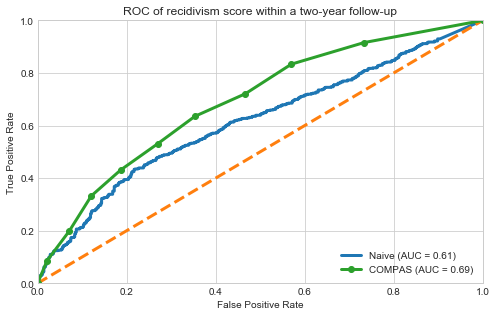

In [50]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], results[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Naive (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(outcome[:,0], compas[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-o",
    label='COMPAS (AUC = %0.2f)'% roc_auc,  linewidth=3)



# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()

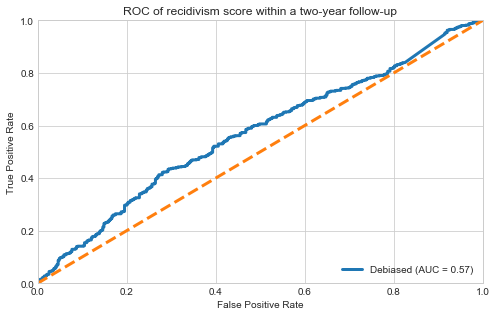

In [51]:
from sklearn.metrics import roc_curve, auc, confusion_matrix



fig = plt.figure()
fig.set_size_inches(7,4.5)
plt.style.use('seaborn-whitegrid')
plt.title('ROC of recidivism score within a two-year follow-up')

# debiased ROC
false_positive_rate, true_positive_rate, thresholds = roc_curve(protected_results[:,0], protected[:,0])
roc_auc = auc(false_positive_rate, true_positive_rate)
plt.plot(false_positive_rate, true_positive_rate, "-",
    label='Debiased (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.plot([0,1],[0,1],'--', linewidth=3)

# COMPAS ROC
#false_positive_rate, true_positive_rate, thresholds = roc_curve(prediction['two_year_recid'], prediction['true'])
#roc_auc = auc(false_positive_rate, true_positive_rate)
#plt.plot(false_positive_rate, true_positive_rate, "-o",
#label='COMPAS decile (AUC = %0.2f)'% roc_auc,  linewidth=3)

plt.legend(loc='lower right')


plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.tight_layout()
plt.show()
#fig.savefig("roc_curve.png", dpi=300,  transparent=True)

In [40]:
df = pd.DataFrame(data=results.numpy(), columns=['pred'])

In [47]:
df['true'] = outcome.numpy()
df['compas'] = compas.numpy()
df['race'] = protected_results.numpy()[:,0]
df['race_hat'] = protected.numpy()[:,0]



In [48]:
df.head()

,pred,true,compas,race_hat,race
0,3.875628,1.0,7.0,0.398397,1.0
1,5.417522,0.0,3.0,0.309573,1.0
2,0.000000,0.0,1.0,0.293049,0.0
3,6.088035,1.0,9.0,0.592682,1.0
4,5.287433,1.0,9.0,0.456601,1.0


In [49]:
from bayesian_model import BayesianModel as bm

dem_parity = abs(
        bm(df).P(pred=lambda x: x > 4).given(race=0) 
        - bm(df).P(pred=lambda x: x > 4).given(
            race=1))
print(dem_parity)

0.1653481243614071


In [52]:
eq_op = abs(
        bm(df).P(pred=lambda x: x > 4).given(race=0, compas=True) 
        - bm(df).P(pred=lambda x: x > 4).given(race=1, compas=True))

print(eq_op)

0.16093948860349416


In [53]:
dem_parity_ratio = abs(
        bm(df).P(pred=lambda x: x > 4).given(race=0) 
        / bm(df).P(pred=lambda x: x > 4).given(
            race=1))
print(dem_parity_ratio)



0.7751845677542272
